<a href="https://colab.research.google.com/github/jbeen2/Today-I-Learned/blob/main/2020-2-NLP/1_DocumentClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Document Clustering 
* G&I corpus:  https://github.com/Ewha-Bio/Genomics-Informatics-Corpus/tree/master/raw_text2 

1. 위의 링크에 저장되어 있는 논문들을 통해 **corpus**를 만들고, 
2. 이를 기반으로 **tf-idf matrix**를 만들어 특성을 추출합니다. 
3. **Unsupervised Learning** 을 통해 문서들의 특성에 따라 **Clustering**합니다. 

--- 

* 참고 : https://github.com/brandomr/document_cluster 






In [4]:
import numpy as np
import pandas as pd

import nltk
from bs4 import BeautifulSoup
import re
import os
import glob
import codecs

from sklearn import feature_extraction
import mpld3

## 0. Load Data 
* txt 파일을 불러옵니다. 

In [5]:
cd /content/drive/MyDrive/Stat/2020-2-NLP/1-DocumentClustering

/content/drive/MyDrive/Stat/2020-2-NLP/1-DocumentClustering


In [6]:
!git clone https://github.com/Ewha-Bio/Genomics-Informatics-Corpus.git

fatal: destination path 'Genomics-Informatics-Corpus' already exists and is not an empty directory.


In [6]:
cd /content/drive/MyDrive/Stat/2020-2-NLP/1-DocumentClustering/Genomics-Informatics-Corpus/raw_text2

/content/drive/MyDrive/Stat/2020-2-NLP/1-DocumentClustering/Genomics-Informatics-Corpus/raw_text2


In [7]:
file_list = os.listdir("./")
file_list_txt = [file for file in file_list if file.endswith(".txt")]

In [8]:
# 논문의 개수 
len(file_list_txt)

487

In [9]:
# 논문 저장 파일 
file_list_txt[:10]

['gni-10-2-110.txt',
 'gni-10-2-117.txt',
 'gni-10-2-123.txt',
 'gni-10-2-128.txt',
 'gni-10-2-69.txt',
 'gni-10-2-74.txt',
 'gni-10-2-81.txt',
 'gni-10-2-88.txt',
 'gni-10-2-99.txt',
 'gni-10-3-133.txt']

In [44]:
title = [open(file_list_txt[i], encoding='UTF-8-sig').read().split('\n')[0] for i in range(len(file_list_txt))]
context = [open(file_list_txt[i], encoding='UTF-8-sig').read().split('\n')[1:] for i in range(len(file_list_txt))]

In [45]:
print(len(title), len(context))

487 487


In [46]:
# dataframe 
# file 제목, 논문의 title, 논문 내용 

documents = pd.DataFrame({
    'file' : file_list_txt, 'title' : title, 'context' : context 
})

In [47]:
documents.head()

,file,title,context
0,gni-10-2-110.txt,Genetic Analysis of SCN5A in Korean Patients A...,[Recent several studies have shown that the ge...
1,gni-10-2-117.txt,Sample Size and Statistical Power Calculation ...,[A sample size with sufficient statistical pow...
2,gni-10-2-123.txt,Performance Comparison of Two Gene Set Analysi...,[Gene set analysis (GSA) is useful in interpre...
3,gni-10-2-128.txt,Characteristics in Molecular Vibrational Frequ...,[To learn the differences between the structur...
4,gni-10-2-69.txt,Perspectives of Integrative Cancer Genomics in...,[The explosive development of genomics technol...


In [49]:
# 데이터 예시 
print('file : ', file_list_txt[0])
print('title : ', title[0])     # 저장 되어 있는 파일 중 가장 첫 번째 문장 
print('context : ', context[0]) # 두 번째 문장부터 저장, 리스트 안에 문장별로 저장

file :  gni-10-2-110.txt
title :  Genetic Analysis of SCN5A in Korean Patients Associated with Atrioventricular Conduction Block
context :  ['Recent several studies have shown that the genetic variation of SCN5A is related with atrioventricular conduction block (AVB); no study has yet been published in Koreans. Therefore, to determine the AVB-associated genetic variation in Korean patients, we investigated the genetic variation of SCN5A in Korean patients with AVB and compared with normal control subjects. We enrolled 113 patients with AVB and 80 normal controls with no cardiac symptoms. DNA was isolated from the peripheral blood, and all exons (exon 2-exon 28) except the untranslated region and exon-intron boundaries of the SCN5A gene were amplified by multiplex PCR and directly sequenced using an ABI PRISM 3100 Genetic Analyzer. When a variation was discovered in genomic DNA from AVB patients, we confirmed whether the same variation existed in the control genomic DNA. In the present 

## 1. Stopwords, Stemming and Tokenizing 
* Stopwords : 불용어를 제거합니다. 
* Stemming : 단어의 어간을 추출합니다.  
* Tokenizing : 전처리 된 단어들을 기반으로, corpus 를 생성합니다. 

In [16]:
# stopwords 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

In [19]:
print('stopwords : ', stopwords[:10])

stopwords :  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [20]:
# load nltk's SnowballStemmer as variabled 'stemmer' 
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [92]:
# 빈 문장 제거 
context2 = [] 
for paper in context : 
    for sent in paper : 
        if not sent == "" : 
            context2.append(sent)

In [85]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [93]:
totalvocab_stemmed = []  
totalvocab_tokenized = []

for i in context2:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [96]:
print(len(totalvocab_stemmed) , len(totalvocab_tokenized))

1066323 1066323


In [97]:
print('context : ', context[0][:3])
print('tokenized context : ', totalvocab_tokenized[:20])
print('stemmed   context : ', totalvocab_stemmed[:20])
print('=====' * 25)
print('# of context tokens : ', len(totalvocab_tokenized))

context :  ['Recent several studies have shown that the genetic variation of SCN5A is related with atrioventricular conduction block (AVB); no study has yet been published in Koreans. Therefore, to determine the AVB-associated genetic variation in Korean patients, we investigated the genetic variation of SCN5A in Korean patients with AVB and compared with normal control subjects. We enrolled 113 patients with AVB and 80 normal controls with no cardiac symptoms. DNA was isolated from the peripheral blood, and all exons (exon 2-exon 28) except the untranslated region and exon-intron boundaries of the SCN5A gene were amplified by multiplex PCR and directly sequenced using an ABI PRISM 3100 Genetic Analyzer. When a variation was discovered in genomic DNA from AVB patients, we confirmed whether the same variation existed in the control genomic DNA. In the present study, a total of 7 genetic variations were detected in 113 AVB patients. Of the 7 variations, 5 (G87A-A29A, intervening sequence

In [118]:
# index : 단어의 stem / words : 해당 단어 
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print(vocab_frame.shape)
vocab_frame.head()

(1066323, 1)


,words
recent,recent
sever,several
studi,studies
have,have
shown,shown


## 2. TF-IDF and Document Similarity 
* **TF-IDF** : 단어의 빈도(Term Frequency)와 역 문서 빈도(Inverse Document Frequency)를 사용하여 각 단어들마다 중요한 정도를 가중치로 주는 방법
    - 단어 빈도 (Term Frequency) = tf(t,d) : 특정 문서 d에서 특정 단어 t의 등장 횟수 
    - 문서 빈도 (Document Frequency) = df(t) : 특정 단어 t가 등장한 문서의 수
    - 역문서 빈도 (Inverse Document Frequency) = idf(t) : df(t)에 반비례하는 수

    - 모든 문서에 많이 나오는 단어는 (ex. a, the, is, …) 굳이 가중치를 높게 줄 필요가 없습니다. 

* $W_{t,d} = tf_{t,d} * log{n \over 1+df(t)}$
    - tf : 단어 빈도 
    - idf : 역문서 빈도 

* cosine similarity 
    - $cos(\theta) = {A * B \over ||A|| * ||B||}$
    - 두 벡터 간의 코사인 각도를 이용하여 구할 수 있는 두 벡터의 유사도 
    - 두 문서들이 완전히 유사하면 1, 완전히 반대라면 -1 값을 가집니다. 
    - (-1 < cos < 1) 값을 가지며 1에 가까울수록 유사도가 높다고 판단할 수 있습니다. 


In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [101]:
# 위에서 만든 tokenize_and_stem 함수를 기반으로, tf-idf tokenizer를 생성합니다. 
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                    min_df=0.2, stop_words='english',
                                    use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

In [102]:
# context 하나의 string으로 만들기 
documents['context_string'] = documents['context'].apply(lambda x : ''.join(x))

In [112]:
print('# of context : ', len(documents['context_string']))
documents['context_string'][:2]

# of context :  487


0    Recent several studies have shown that the gen...
1    A sample size with sufficient statistical powe...
Name: context_string, dtype: object

In [103]:
# tokenizer 를 context 에 적용합니다. 
%time tfidf_matrix = tfidf_vectorizer.fit_transform(documents['context_string'])

print(tfidf_matrix.shape)   # 논문 487개, token 497개 

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 29.3 s, sys: 274 ms, total: 29.6 s
Wall time: 29.6 s
(487, 497)


In [106]:
context_terms = tfidf_vectorizer.get_feature_names()

In [107]:
# unique 한 title token 
len(context_terms)

497

In [108]:
# stemming 까지 적용하여 tokenize 된 context token 들 
context_terms[:20]

["'s",
 '.in',
 '.the',
 'abl',
 'abov',
 'access',
 'accord',
 'accur',
 'accuraci',
 'achiev',
 'acid',
 'activ',
 'ad',
 'addit',
 'advanc',
 'advantag',
 'affect',
 'age',
 'aim',
 'al']

In [109]:
# 각각의 논문들 사이의 cosine similarity (문서 간의 유사도)
dist = 1 - cosine_similarity(tfidf_matrix)

## 3. K-means Clustering 
* Clustering : 비슷한 개체끼리 한 그룹으로 묶는 것을 말합니다. 
* 사전에 군집의 개수(K)가 정해지고, 각 군집은 하나의 중심(centroid)을 가집니다. 
* 각 개체는 가장 가까운 중심에 할당되며, 같은 중심에 할당된 개체들이 모여 하나의 군집을 형성합니다. 
* 모든 점에 대해 최적화 된 군집을 찾을 때 까지, 위와 같은 과정이 업데이트 됩니다. (Unsupervised) 

In [113]:
from sklearn.cluster import KMeans

In [114]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 10 s, sys: 5.15 ms, total: 10 s
Wall time: 10.1 s


In [115]:
# class 다섯개로 분류된 context 
len(clusters)

487

In [116]:
documents["cluster"] = clusters
documents["cluster"].value_counts()

3    165
4    110
1    100
0     57
2     55
Name: cluster, dtype: int64

In [117]:
documents.head()

,file,title,context,context_string,cluster
0,gni-10-2-110.txt,Genetic Analysis of SCN5A in Korean Patients A...,[Recent several studies have shown that the ge...,Recent several studies have shown that the gen...,1
1,gni-10-2-117.txt,Sample Size and Statistical Power Calculation ...,[A sample size with sufficient statistical pow...,A sample size with sufficient statistical powe...,1
2,gni-10-2-123.txt,Performance Comparison of Two Gene Set Analysi...,[Gene set analysis (GSA) is useful in interpre...,Gene set analysis (GSA) is useful in interpret...,1
3,gni-10-2-128.txt,Characteristics in Molecular Vibrational Frequ...,[To learn the differences between the structur...,To learn the differences between the structure...,2
4,gni-10-2-69.txt,Perspectives of Integrative Cancer Genomics in...,[The explosive development of genomics technol...,The explosive development of genomics technolo...,4


In [122]:
# 각각의 cluster 마다 자주 나온 단어를 거리가 가까운 값 순서대로 인덱스로 정렬한 것
print(order_centroids.shape)
order_centroids

(5, 497)


array([[ 20, 165, 163, ...,  53,  14, 478],
       [437,  42, 202, ..., 207, 407, 347],
       [365, 449, 243, ...,  62, 205,  61],
       [419, 119, 238, ..., 236, 333, 340],
       [ 64, 176,  69, ..., 155,  44, 340]])

In [127]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.loc[context_terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in documents[documents['cluster'] == i]['title'][:5] :
        print(' %s,' % title, end='')
    print()
    print()

    print()

Top terms per cluster:

Cluster 0 words: b'al.', b'et', b'et', b'cell', b'expressed', b'association',

Cluster 0 titles: Changes of Gene Expression in NIH3T3 Cells Exposed to Osmotic and Oxidative Stresses, Identification of the Marker-Genes for Dioxin(2,3,7,8- tetradibenzo-p-dioxin)-Induced Immune Dysfunction by Using the High-Density Oligonucleotide Microarray, No Evidence of Association of Interleukin 1A (-889) Genetic Polymorphism with Alzheimer’s Disease in Koreans, High Correlation between Alu Elements and the Conversion of 3’ UTR of mRNAs Processed Pseudogenes, Current Status and Future Clinical Applications of Array based Comparative Genomic Hybridization,


Cluster 1 words: b'snps', b'association', b'genetic', b'genotype', b'snp', b'populations',

Cluster 1 titles: Genetic Analysis of SCN5A in Korean Patients Associated with Atrioventricular Conduction Block, Sample Size and Statistical Power Calculation in Genetic Association Studies, Performance Comparison of Two Gene Set An

## 4. Multidimensional Scaling 
* 자료들의 '비유사성' 거리를 바탕으로, 다중의 변수들을 2차원 혹은 3차원으로 낮추어 나타내는 기법입니다. 
* 낮은 차원에서의 자료들이 거리가 멀리 떨어져 위치한다는 것은 비유사성이 높다는 뜻이고, 
* 자료가 가까울수록 비유사성이 낮다 (= 유사성이 높다) 는 뜻이 됩니다. 

* 위에서 구한 **cosine similarity**를 기반으로 유사성을 구하고, 이를 2차원으로 projection 하여 논문들 사이의 유사도를 판단합니다.

In [128]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

In [129]:
MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1] # pos : 객체들의 새로운 좌표

In [130]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

In [131]:
#set up cluster names using a dict
cluster_names = {0: 'cell, expressed, association', 
                 1: 'snps, genetic, genotype, populations' ,
                 2: 'proteins, structure, interaction, domains, sequenced, model',
                 3: 'sequenced, databases, information, dna, users, files', 
                 4: 'cancer, expressed, cell, mutation, patients, tumor' }

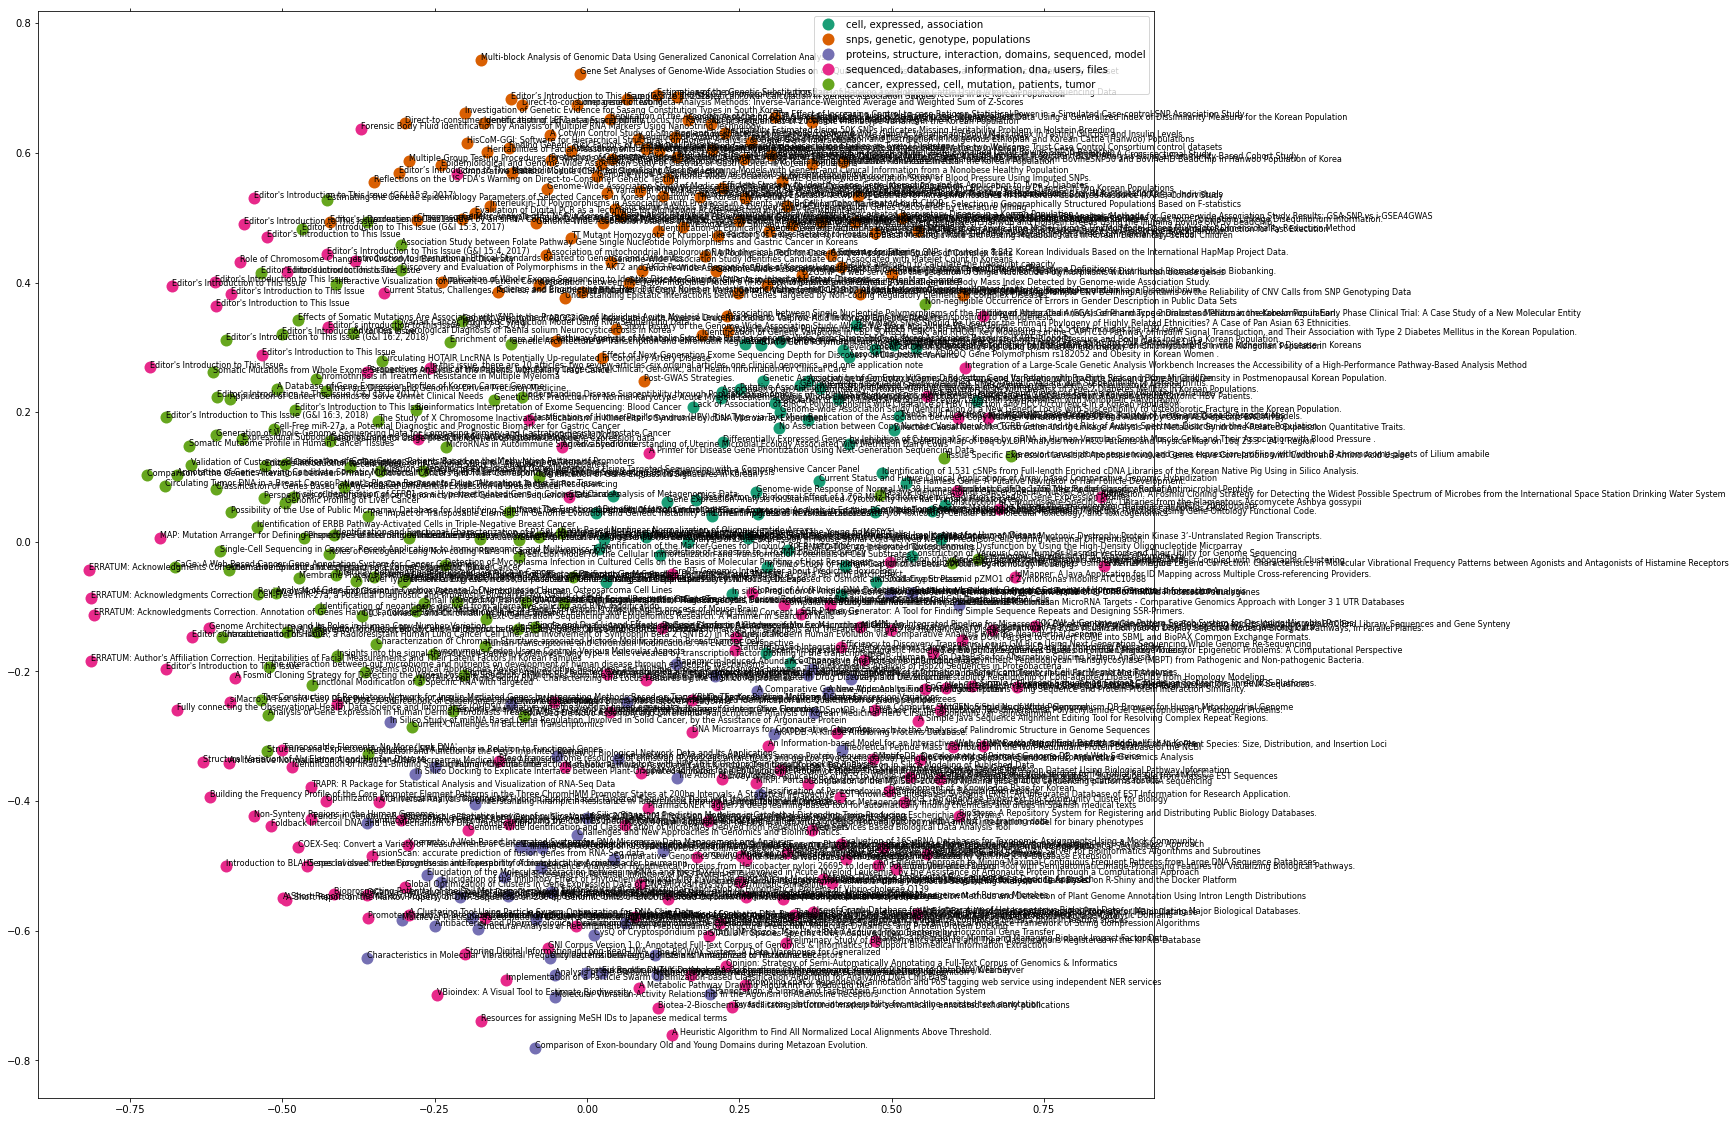

In [142]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=documents['cluster'], title=documents['title'])) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(20, 20)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot